## Part A

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [109]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/property_data_clustering_clean.csv"
df = pd.read_csv(url)
df.head(10)

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Terjual/Belum,Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
0,Standard,Citraland,240,300,4,3,2,3500000000,Belum,Utara,Standard,1-2 Mobil
1,Below Standard,Setro Baru Utara,30,60,2,1,2,287799000,Belum,Utara,Standard,< 1 Mobil
2,Standard,Kenjeran,170,170,5,4,2,2699999999,Belum,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil
3,Sangat Premium,Kenjeran,187,250,5,5,2,3100000000,Belum,Utara,Standard,1-2 Mobil
4,Premium,Kenjeran,350,600,5,5,2,5000000000,Belum,Barat,Standard,1-2 Mobil
5,Premium,Kenjeran,450,530,5,6,2,10800000000,Belum,Utara,Standard,1-2 Mobil
6,Below Standard,Gubeng,96,60,2,1,1,390000000,Belum,Utara,Standard,1-2 Mobil
7,Premium,Gubeng,85,100,3,2,2,725000000,Belum,Utara,Standard,1-2 Mobil
8,Below Standard,Sawahan,72,120,4,1,1,775000000,Belum,Barat,Tikungan/Hook,< 1 Mobil
9,Standard,Gubeng,50,100,2,2,2,850000000,Belum,Utara,Standard,1-2 Mobil


In [110]:
df.drop(columns=['Terjual/Belum'], inplace=True)

In [111]:
# describe data
df.describe()

,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner)
count,308.000000,308.000000,308.000000,308.000000,308.000000,3.080000e+02
mean,226.951299,266.688312,4.275974,3.337662,1.840909,5.014301e+09
std,201.821447,213.161697,1.643804,1.627215,0.507932,8.311434e+09
min,14.000000,14.000000,1.000000,1.000000,1.000000,1.600000e+08
25%,96.000000,120.000000,3.000000,2.000000,2.000000,1.400000e+09
50%,162.500000,200.000000,4.000000,3.000000,2.000000,2.699500e+09
75%,283.000000,328.750000,5.000000,4.000000,2.000000,4.891667e+09
max,1561.000000,1200.000000,13.000000,13.000000,4.000000,9.900000e+10


In [112]:
# Check for info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Area Category                  308 non-null    object
 1   Nama Daerah                    308 non-null    object
 2   Luas Tanah (m2)                308 non-null    int64 
 3   Luas Bangunan (m2)             308 non-null    int64 
 4   Jumlah Kamar                   308 non-null    int64 
 5   Jumlah Kamar Mandi             308 non-null    int64 
 6   Tingkat/Lantai                 308 non-null    int64 
 7   Harga Penawaran (dari Owner)   308 non-null    int64 
 8   Arah Hadap Rumah               308 non-null    object
 9   Posisi Rumah                   308 non-null    object
 10  Lebar Jalan Depan Rumah (ROW)  308 non-null    object
dtypes: int64(6), object(5)
memory usage: 26.6+ KB


In [113]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)
missing_table = pd.concat([missing_counts, missing_pct], axis=1)
missing_table.columns = ['missing_count', 'missing_pct']
missing_table

,missing_count,missing_pct
Area Category,0,0.0
Nama Daerah,0,0.0
Luas Tanah (m2),0,0.0
Luas Bangunan (m2),0,0.0
Jumlah Kamar,0,0.0
Jumlah Kamar Mandi,0,0.0
Tingkat/Lantai,0,0.0
Harga Penawaran (dari Owner),0,0.0
Arah Hadap Rumah,0,0.0
Posisi Rumah,0,0.0


In [114]:
# Hapus spasi berlebih di nama kolom
df.columns = df.columns.str.strip()


In [115]:
# Daftar kolom kategorik
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for c in cat_cols:
    print(f"\n=== Column: {c} ===")
    print(df[c].value_counts(dropna=False))
    print("-" * 50)



=== Column: Area Category ===
Area Category
Standard          140
Premium           106
Below Standard     36
Sangat Premium     26
Name: count, dtype: int64
--------------------------------------------------

=== Column: Nama Daerah ===
Nama Daerah
Citraland           34
Gubeng              19
Mulyorejo           18
Pakuwon City        16
Wiyung              11
                    ..
Pakal                1
Asemrowo             1
Tenggilis Mejoyo     1
Dukuh Pakis          1
Teuku Umar           1
Name: count, Length: 126, dtype: int64
--------------------------------------------------

=== Column: Arah Hadap Rumah ===
Arah Hadap Rumah
Utara      165
Selatan     80
Timur       44
Barat       19
Name: count, dtype: int64
--------------------------------------------------

=== Column: Posisi Rumah ===
Posisi Rumah
Standard                       277
Tikungan/Hook                   25
Cul De Sac/Ujung Gang Buntu      3
Tusuk Sate                       2
Kantong Belakang/Ngantong        1


## Part B

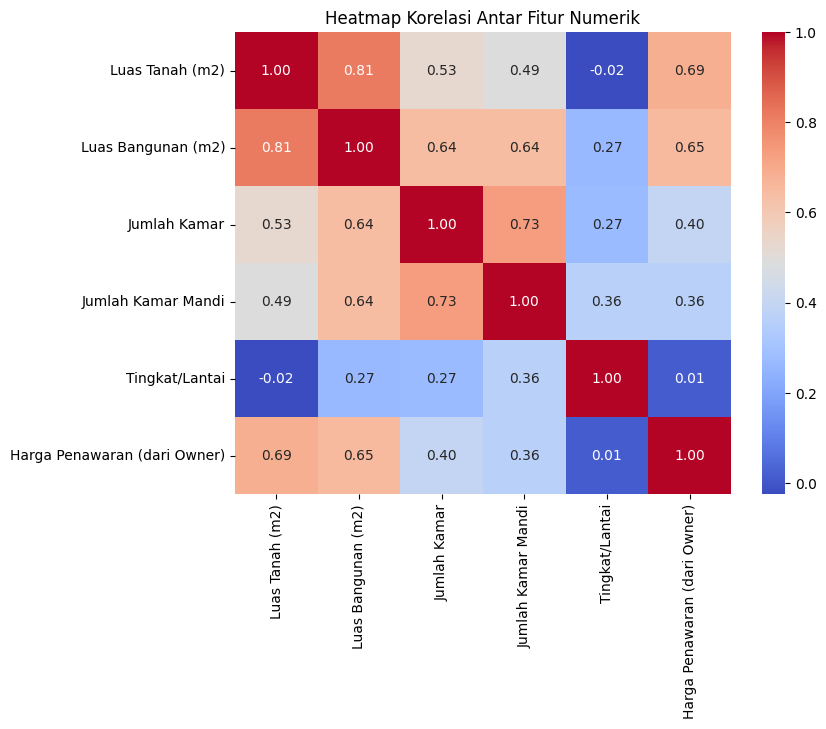

In [116]:
num_cols = ['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar',
            'Jumlah Kamar Mandi', 'Tingkat/Lantai', 'Harga Penawaran (dari Owner)']

corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()


dari visualisasi heatmap diatas, diketahui bahwa yang memiliki relasi tertinggi adalah luas tanah dengan luas bangunan dimana ini saling mempengaruhi, di posisi kedua adalah jumlah kamar dan jumlah kamar mandi yang lumayan memiliki relasi

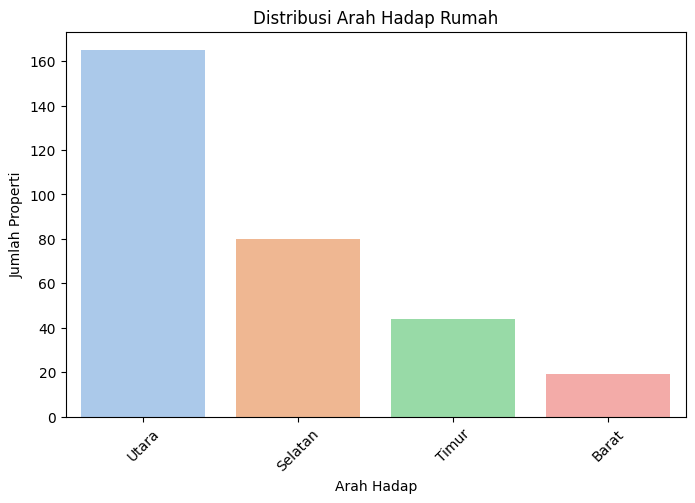

In [117]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='Arah Hadap Rumah',
    order=df['Arah Hadap Rumah'].value_counts().index,
    palette='pastel'
)
plt.title('Distribusi Arah Hadap Rumah')
plt.xlabel('Arah Hadap')
plt.ylabel('Jumlah Properti')
plt.xticks(rotation=45)
plt.show()


dari visualisasi diatas, kebanyakan rumah menghadap kearah Utara dan yang paling sedikit menghadap kearah barat

# Part C

In [118]:
from sklearn.preprocessing import LabelEncoder

# Salin dataframe asli
df_encoded = df.copy()

# Nominal Encoding untuk kolom yang tidak memiliki urutan (Area Category, Nama Daerah, Arah Hadap Rumah)
label_encoder = LabelEncoder()
df_encoded['Area Category'] = label_encoder.fit_transform(df['Area Category'])
df_encoded['Nama Daerah'] = label_encoder.fit_transform(df['Nama Daerah'])
df_encoded['Arah Hadap Rumah'] = label_encoder.fit_transform(df['Arah Hadap Rumah'])

# Ordinal Encoding untuk kolom dengan urutan yang jelas (Posisi Rumah, Lebar Jalan Depan Rumah)
posisi_rumah_order = {'Standard': 0, 'Tikungan/Hook': 1, 'Cul De Sac/Ujung Gang Buntu': 2,
                      'Tusuk Sate': 3, 'Kantong Belakang/Ngantong': 4}
lebar_jalan_order = {'< 1 Mobil': 0, '1-2 Mobil': 1, '> 2 Mobil': 2}

df_encoded['Posisi Rumah'] = df['Posisi Rumah'].map(posisi_rumah_order)
df_encoded['Lebar Jalan Depan Rumah (ROW)'] = df['Lebar Jalan Depan Rumah (ROW)'].map(lebar_jalan_order)

# Lihat hasil encoding
df_encoded.head(20)


,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
0,3,11,240,300,4,3,2,3500000000,3,0,1
1,0,100,30,60,2,1,2,287799000,3,0,0
2,3,48,170,170,5,4,2,2699999999,1,2,1
3,2,48,187,250,5,5,2,3100000000,3,0,1
4,1,48,350,600,5,5,2,5000000000,0,0,1
5,1,48,450,530,5,6,2,10800000000,3,0,1
6,0,30,96,60,2,1,1,390000000,3,0,1
7,1,30,85,100,3,2,2,725000000,3,0,1
8,0,98,72,120,4,1,1,775000000,0,1,0
9,3,30,50,100,2,2,2,850000000,3,0,1


In [119]:
from sklearn.preprocessing import StandardScaler

# Pilih fitur numerik
num_cols = ['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar',
            'Jumlah Kamar Mandi', 'Tingkat/Lantai', 'Harga Penawaran (dari Owner)']

# Standarisasi fitur numerik
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Lihat hasil standardisasi
df_encoded.head()


,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
0,3,11,0.064760,0.156529,-0.168161,-0.207847,0.313723,-0.182491,3,0,1
1,0,100,-0.977457,-0.971209,-1.386831,-1.438941,0.313723,-0.569600,3,0,0
2,3,48,-0.282646,-0.454330,0.441174,0.407700,0.313723,-0.278901,1,2,1
3,2,48,-0.198276,-0.078417,0.441174,1.023247,0.313723,-0.230696,3,0,1
4,1,48,0.610683,1.566201,0.441174,1.023247,0.313723,-0.001723,0,0,1


In [120]:
scaler = StandardScaler()

# Kolom numerik yang akan distandarisasi
num_cols = ['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar',
            'Jumlah Kamar Mandi', 'Tingkat/Lantai', 'Harga Penawaran (dari Owner)']

# Standarisasi fitur numerik
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Lihat hasil encoding dan standarisasi
df_encoded.head()

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
0,3,11,0.064760,0.156529,-0.168161,-0.207847,0.313723,-0.182491,3,0,1
1,0,100,-0.977457,-0.971209,-1.386831,-1.438941,0.313723,-0.569600,3,0,0
2,3,48,-0.282646,-0.454330,0.441174,0.407700,0.313723,-0.278901,1,2,1
3,2,48,-0.198276,-0.078417,0.441174,1.023247,0.313723,-0.230696,3,0,1
4,1,48,0.610683,1.566201,0.441174,1.023247,0.313723,-0.001723,0,0,1


In [121]:
# get stastical information on the new dataset
df_encoded.describe()

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
count,308.000000,308.000000,3.080000e+02,3.080000e+02,308.000000,308.000000,3.080000e+02,3.080000e+02,308.000000,308.000000,308.000000
mean,1.876623,61.448052,2.306957e-17,8.651089e-18,0.000000,0.000000,-1.730218e-17,-1.297663e-17,2.152597,0.133117,1.331169
std,1.120307,36.863343,1.001627e+00,1.001627e+00,1.001627,1.001627,1.001627e+00,1.001627e+00,1.011059,0.462053,0.553993
min,0.000000,0.000000,-1.056864e+00,-1.187359e+00,-1.996166,-1.438941,-1.658248e+00,-5.850015e-01,0.000000,0.000000,0.000000
25%,1.000000,29.750000,-6.499032e-01,-6.892750e-01,-0.777496,-0.823394,3.137225e-01,-4.355666e-01,1.000000,0.000000,1.000000
50%,2.000000,63.500000,-3.198678e-01,-3.133623e-01,-0.168161,-0.207847,3.137225e-01,-2.789613e-01,3.000000,0.000000,1.000000
75%,3.000000,94.000000,2.781662e-01,2.916222e-01,0.441174,0.407700,3.137225e-01,-1.477895e-02,3.000000,0.000000,2.000000
max,3.000000,125.000000,6.620801e+00,4.385546e+00,5.315854,5.947624,4.257663e+00,1.132640e+01,3.000000,4.000000,2.000000


## Silhouette Score

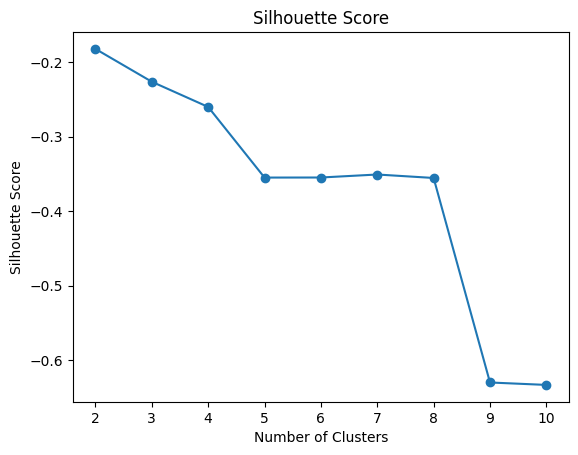

In [122]:
# this is way to show only 1 sillhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = []

for i in range(2, 11):
    # Create a new AgglomerativeClustering instance for each number of clusters
    agglo_model = AgglomerativeClustering(n_clusters=i, linkage='single')
    cluster_labels = agglo_model.fit_predict(df_encoded)
    silhouette_avg = silhouette_score(df_encoded, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score = the higher the better
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

## Comparing Silhouette Score to get best combination of linkage and metric

Skipping Ward linkage with Manhattan metric (not supported).


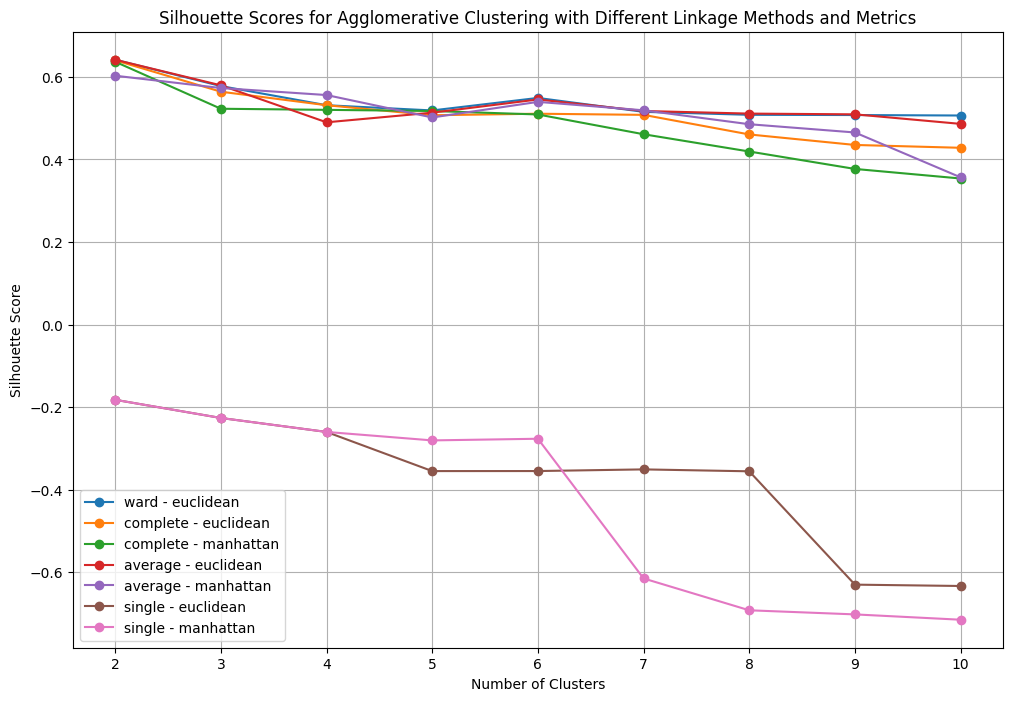

Best Silhouette Score: 0.6416933985277203
Optimal Number of Clusters: 2
Optimal Linkage Method: ward
Optimal Metric: euclidean


In [123]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_encoded)
            silhouette_avg = silhouette_score(df_encoded, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

# Part D

In [134]:
from sklearn.cluster import AgglomerativeClustering

# Gunakan hasil terbaik dari Part C
print("Best parameters from previous step:")
print(f"Linkage: {best_linkage}")
print(f"Metric: {best_metric}")
print(f"n_clusters: {best_n_clusters}")

# Model 1 - menggunakan parameter terbaik
model_best = AgglomerativeClustering(
    n_clusters=best_n_clusters,
    linkage=best_linkage,
    metric=best_metric
)
labels_best = model_best.fit_predict(df_encoded)

print("Model 1 (Best Combination) selesai dibuat ✅")


Best parameters from previous step:
Linkage: ward
Metric: euclidean
n_clusters: 2
Model 1 (Best Combination) selesai dibuat ✅


In [135]:
# Model 2 - menggunakan Ward linkage (harus euclidean)
model_ward = AgglomerativeClustering(
    n_clusters=best_n_clusters,
    linkage='ward',
    metric='euclidean'
)
labels_ward = model_ward.fit_predict(df_encoded)

print("Model 2 (Ward Linkage) selesai dibuat ✅")


Model 2 (Ward Linkage) selesai dibuat ✅


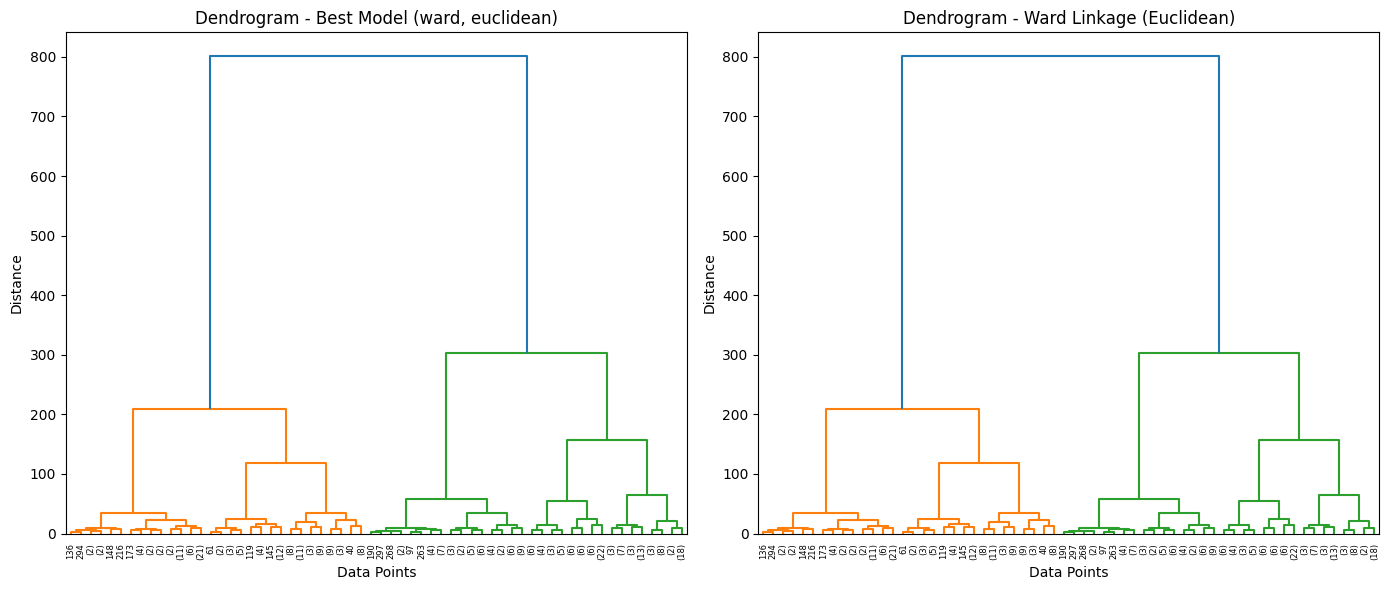

In [136]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Dendrogram Model 1 (Best)
plt.subplot(1, 2, 1)
linkage_matrix_best = linkage(df_encoded, method=best_linkage, metric=best_metric)
dendrogram(linkage_matrix_best, truncate_mode='level', p=5)
plt.title(f"Dendrogram - Best Model ({best_linkage}, {best_metric})")
plt.xlabel("Data Points")
plt.ylabel("Distance")

# Dendrogram Model 2 (Ward)
plt.subplot(1, 2, 2)
linkage_matrix_ward = linkage(df_encoded, method='ward', metric='euclidean')
dendrogram(linkage_matrix_ward, truncate_mode='level', p=5)
plt.title("Dendrogram - Ward Linkage (Euclidean)")
plt.xlabel("Data Points")
plt.ylabel("Distance")

plt.tight_layout()
plt.show()


In [137]:
import pandas as pd

# Gabungkan hasil cluster ke dataset asli
df_with_clusters = df.copy()
df_with_clusters['Cluster_Best'] = labels_best
df_with_clusters['Cluster_Ward'] = labels_ward

# Tampilkan beberapa data
print("Cluster assignment (first 10 rows):")
display(df_with_clusters[['Cluster_Best', 'Cluster_Ward']].head(10))

# Lihat karakteristik rata-rata tiap cluster
print("\n=== Property Characteristics per Cluster (Best Model) ===")
display(df_with_clusters.groupby('Cluster_Best').mean(numeric_only=True))

print("\n=== Property Characteristics per Cluster (Ward Model) ===")
display(df_with_clusters.groupby('Cluster_Ward').mean(numeric_only=True))


Cluster assignment (first 10 rows):


,Cluster_Best,Cluster_Ward
0,1,1
1,0,0
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,0,0
9,1,1



=== Property Characteristics per Cluster (Best Model) ===


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Agglo,Cluster_Ward
Cluster_Best,,,,,,,,
0,200.452941,227.505882,4.035294,3.076471,1.829412,3.814940e+09,0.0,0.0
1,259.594203,314.956522,4.572464,3.659420,1.855072,6.491776e+09,1.0,1.0



=== Property Characteristics per Cluster (Ward Model) ===


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Agglo,Cluster_Best
Cluster_Ward,,,,,,,,
0,200.452941,227.505882,4.035294,3.076471,1.829412,3.814940e+09,0.0,0.0
1,259.594203,314.956522,4.572464,3.659420,1.855072,6.491776e+09,1.0,1.0


# Part E

In [138]:
# 🔹 Distribusi data per cluster
print("=== Cluster Distribution (Best Model) ===")
display(df_with_clusters['Cluster_Best'].value_counts().sort_index())

print("\n=== Cluster Distribution (Ward Model) ===")
display(df_with_clusters['Cluster_Ward'].value_counts().sort_index())

# 🔹 Statistik rata-rata dan median per cluster
print("\n=== Mean Values per Cluster (Best Model) ===")
display(df_with_clusters.groupby('Cluster_Best').mean(numeric_only=True))

print("\n=== Median Values per Cluster (Best Model) ===")
display(df_with_clusters.groupby('Cluster_Best').median(numeric_only=True))

print("\n=== Mean Values per Cluster (Ward Model) ===")
display(df_with_clusters.groupby('Cluster_Ward').mean(numeric_only=True))

print("\n=== Median Values per Cluster (Ward Model) ===")
display(df_with_clusters.groupby('Cluster_Ward').median(numeric_only=True))

print("\n=== Mode Values per Cluster (Best Model) ===")
display(df_with_clusters.groupby('Cluster_Best').agg(lambda x: x.mode().iloc[0]))

print("\n=== Mode Values per Cluster (Ward Model) ===")
display(df_with_clusters.groupby('Cluster_Ward').agg(lambda x: x.mode().iloc[0]))



=== Cluster Distribution (Best Model) ===


,count
Cluster_Best,
0,170
1,138



=== Cluster Distribution (Ward Model) ===


,count
Cluster_Ward,
0,170
1,138



=== Mean Values per Cluster (Best Model) ===


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Agglo,Cluster_Ward
Cluster_Best,,,,,,,,
0,200.452941,227.505882,4.035294,3.076471,1.829412,3.814940e+09,0.0,0.0
1,259.594203,314.956522,4.572464,3.659420,1.855072,6.491776e+09,1.0,1.0



=== Median Values per Cluster (Best Model) ===


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Agglo,Cluster_Ward
Cluster_Best,,,,,,,,
0,150.0,186.0,4.0,3.0,2.0,2.400000e+09,0.0,0.0
1,200.0,241.5,5.0,4.0,2.0,3.100000e+09,1.0,1.0



=== Mean Values per Cluster (Ward Model) ===


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Agglo,Cluster_Best
Cluster_Ward,,,,,,,,
0,200.452941,227.505882,4.035294,3.076471,1.829412,3.814940e+09,0.0,0.0
1,259.594203,314.956522,4.572464,3.659420,1.855072,6.491776e+09,1.0,1.0



=== Median Values per Cluster (Ward Model) ===


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Agglo,Cluster_Best
Cluster_Ward,,,,,,,,
0,150.0,186.0,4.0,3.0,2.0,2.400000e+09,0.0,0.0
1,200.0,241.5,5.0,4.0,2.0,3.100000e+09,1.0,1.0



=== Mode Values per Cluster (Best Model) ===


,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW),Agglo,Cluster_Ward
Cluster_Best,,,,,,,,,,,,,
0,Standard,Mulyorejo,120,200,4,3,2,3500000000,Utara,Standard,1-2 Mobil,0,0
1,Standard,Citraland,240,120,5,4,2,725000000,Utara,Standard,1-2 Mobil,1,1



=== Mode Values per Cluster (Ward Model) ===


,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW),Agglo,Cluster_Best
Cluster_Ward,,,,,,,,,,,,,
0,Standard,Mulyorejo,120,200,4,3,2,3500000000,Utara,Standard,1-2 Mobil,0,0
1,Standard,Citraland,240,120,5,4,2,725000000,Utara,Standard,1-2 Mobil,1,1


Berdasarkan hasil analisis clustering, data properti terbagi menjadi dua kelompok utama. Cluster 0 terdiri dari sekitar 170 properti dengan karakteristik rata-rata luas tanah sekitar 200 m² dan luas bangunan sekitar 227 m². Harga penawaran pada kelompok ini relatif lebih terjangkau, yaitu sekitar Rp 3,8 miliar, dan sebagian besar properti berlokasi di Mulyorejo. Dengan demikian, cluster ini dapat dikategorikan sebagai segmen rumah menengah, yang umumnya ditujukan bagi keluarga muda atau pembeli yang mencari hunian nyaman dengan harga yang masih terjangkau.

Sementara itu, Cluster 1 mencakup sekitar 138 properti dengan ukuran yang lebih besar luas tanah rata-rata 260 m² dan luas bangunan sekitar 315 m². Harga penawarannya juga jauh lebih tinggi, mencapai sekitar Rp 6,5 miliar, dengan dominasi lokasi di Citraland. Hal ini menunjukkan bahwa cluster ini merepresentasikan segmen rumah premium atau kelas atas, yang umumnya menarik bagi pembeli dengan daya beli tinggi maupun investor properti jangka panjang.

Jika dibandingkan, hasil antara model dengan kombinasi parameter terbaik dan model menggunakan Ward linkage menunjukkan pola yang serupa. Namun, model dengan Ward linkage menghasilkan pembentukan cluster yang lebih stabil dan terstruktur dari sisi hierarki.

Dari perspektif bisnis, hasil clustering ini dapat dimanfaatkan untuk menyusun strategi pemasaran yang lebih tepat sasaran. Contohnya, area Mulyorejo dapat difokuskan pada segmen pasar keluarga menengah dengan kisaran harga Rp 3–4 miliar, sedangkan Citraland dapat diposisikan sebagai area eksklusif dengan promosi rumah mewah di kisaran Rp 6–7 miliar. Selain itu, agen properti dapat menyesuaikan pendekatan penjualannya seperti promosi digital dan penawaran diskon untuk segmen menengah, serta pendekatan eksklusif seperti private showing untuk segmen premium.